<h2 style="text-align: center;">FMUP Assignment 1</h1>
<h2 style="text-align: center;">Name : Siddhesh Maheshwari</h2>
<h2 style="text-align: center;">MDS202347</h2>

Step 1: Importing Neccesey libraries

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime,date
from scipy.stats import gennorm, norm
from scipy.special import gamma
import matplotlib.pyplot as plt
import yfinance as yf
import math
import copulae
from copulae import StudentCopula
from copulae import pseudo_obs
from tabulate import tabulate
pd.set_option('display.max_rows', None)
copulae.__version__

'0.7.9'

1. Suppose a student has taken an education load of size Rs 0.8 million. The
interest rate is 12%. Write a python program that generates the schedule of
repayment of the loan in 5 years (or ‘n’ number of years). Assume the first
payment date is 01 January 2026. Also, show the breakup of each payment is
principal and interest.

The EMI is calculated using the annuity formula:

$$
EMI = P \times r \times \frac{(1 + r)^n}{(1 + r)^n - 1}
$$

Where:  
-  P = Principal loan amount  
-  r = Monthly interest rate (annual interest rate divided by 12)  
- n = Total number of monthly payments


Note : For our calculation 1 month is 1 calender month

In [2]:
# Function to generate loan repayment schedule
def generate_loan_schedule(principal, annual_rate, years, start_date_str):
    monthly_rate = (annual_rate / 12) / 100  # Monthly interest rate
    n_months = years * 12  # Total number of payments
    
    # Calculate EMI using the annuity formula
    emi = principal * monthly_rate * (1 + monthly_rate)**n_months / ((1 + monthly_rate)**n_months - 1)
    
    schedule = []
    balance = principal
    start_date = datetime.strptime(start_date_str, "%d-%m-%Y")
    
    for i in range(1, n_months + 1):
        interest = balance * monthly_rate
        principal_payment = emi - interest
        balance -= principal_payment
        payment_date = start_date + pd.DateOffset(months=i-1)
        
        schedule.append({
            'Payment No': i,
            'Payment Date': payment_date.strftime("%d-%b-%Y"),
            'EMI': round(emi, 2),
            'Principal Paid': round(principal_payment, 2),
            'Interest Paid': round(interest, 2),
            'Outstanding Balance': round(balance if balance > 0 else 0, 2)
        })
    
    return pd.DataFrame(schedule)

In [3]:
df_schedule = generate_loan_schedule(
    principal=800000, 
    annual_rate=12, 
    years=5, 
    start_date_str="01-01-2026"
)

In [4]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(tabulate(df_schedule, headers='keys', tablefmt='fancy_grid', showindex=False))

╒══════════════╤════════════════╤═════════╤══════════════════╤═════════════════╤═══════════════════════╕
│   Payment No │ Payment Date   │     EMI │   Principal Paid │   Interest Paid │   Outstanding Balance │
╞══════════════╪════════════════╪═════════╪══════════════════╪═════════════════╪═══════════════════════╡
│            1 │ 01-Jan-2026    │ 17795.6 │          9795.56 │         8000    │              790204   │
├──────────────┼────────────────┼─────────┼──────────────────┼─────────────────┼───────────────────────┤
│            2 │ 01-Feb-2026    │ 17795.6 │          9893.51 │         7902.04 │              780311   │
├──────────────┼────────────────┼─────────┼──────────────────┼─────────────────┼───────────────────────┤
│            3 │ 01-Mar-2026    │ 17795.6 │          9992.45 │         7803.11 │              770318   │
├──────────────┼────────────────┼─────────┼──────────────────┼─────────────────┼───────────────────────┤
│            4 │ 01-Apr-2026    │ 17795.6 │         100

2. Consider a 20-years 8% bond with the coupon paid semi-annually. What will be
the present value of the bond? Use the following spot rates tables to compute
the present value. Also, compute duration and convexity.


### **Given Data**
| Period | Spot Rate (Annual) |
|--------|--------------------|
| 6M     | 2.90%              |
| 1 Yr   | 4.40%              |
| 2 Yr   | 4.80%              |
| 3 Yr   | 5.00%              |
| 5 Yr   | 5.30%              |
| 10 Yr  | 5.40%              |
| 20 Yr  | 5.50%              |

### Bond Valuation Formulas

#### 1. Semi-Annual Coupon Payment
$$
C = \frac{\text{Coupon Rate} \times \text{Face Value}}{2}
$$

---

#### 2. Linear Interpolation of Spot Rate
If the spot rate for the desired period $$ t$$ is not directly given:
$$
r_t = r_0 + \left( \frac{r_1 - r_0}{t_1 - t_0} \right)(t - t_0)
$$
Where:  
- r_0 and  r_1 are the spot rates at the nearest lower and higher time points  t_0 and  t_1 respectively.

---

#### 3. Discount Factor (for semi-annual compounding)
$$
DF_t = \frac{1}{\left(1 + \frac{r_t}{2} \right)^{2t}}
$$

---

#### 4. Present Value of the Bond
$$
PV = \sum_{t=1}^{T} \left( CF_t \times DF_t \right)
$$
Where:  
- CF_t is the cash flow at time $$ t$$  
- DF_t is the corresponding discount factor

---

#### 5. Macaulay Duration
$$
D = \frac{ \sum_{t=1}^{T} \left( t \times CF_t \times DF_t \right)}{PV}
$$

---

#### 6. Convexity
$$
\text{Convexity} = \frac{ \sum_{t=1}^{T} \left( CF_t \times DF_t \times t \times \left( t + \frac{1}{2} \right) \right)}{PV \times \left(1 + \frac{r_T}{2} \right)^2}
$$
Where $$ r_T$$ is the spot rate at maturity.


In [ ]:
# Bond parameters
face_value = 100
coupon_rate = 0.08  # 8% annual
semi_annual_coupon = coupon_rate * face_value / 2
years_to_maturity = 20
periods = years_to_maturity * 2

# Given spot rates (period in years, rate in %)
spot_rates = {
    0.5: 0.029,   # 6M
    1: 0.044,     # 1Y
    2: 0.048,     # 2Y
    3: 0.05,      # 3Y
    5: 0.053,     # 5Y
    10: 0.054,    # 10Y
    20: 0.055     # 20Y
}

# Function to interpolate spot rates for any period
def get_spot_rate(period):
    if period <= 0.5:
        return spot_rates[0.5]
    elif period >= 20:
        return spot_rates[20]
    
    # Find the nearest lower and higher periods
    lower_periods = [p for p in spot_rates.keys() if p <= period]
    higher_periods = [p for p in spot_rates.keys() if p > period]

    if not lower_periods or not higher_periods:
        # Extrapolate if necessary
        if not lower_periods:
            return spot_rates[min(spot_rates.keys())]
        else:
            return spot_rates[max(spot_rates.keys())]
    
    lower_period = max(lower_periods)
    higher_period = min(higher_periods)
    
    # Linear interpolation
    x = period
    x0, y0 = lower_period, spot_rates[lower_period]
    x1, y1 = higher_period, spot_rates[higher_period]
    
    return y0 + (x - x0) * (y1 - y0) / (x1 - x0)

# Calculate cash flows and discount factors
cash_flows = [semi_annual_coupon] * periods
cash_flows[-1] += face_value  # Add principal at maturity

period_times = [(i+1)/2 for i in range(periods)]  # in years
spot_rates_list = [get_spot_rate(t) for t in period_times]
print(f"Spot Rates: ")
print([round(rate, 4) for rate in spot_rates_list],"\n") 

discount_factors = [1 / (1 + r/2)**(2*t) for r, t in zip(spot_rates_list, period_times)]


# Present Value calculation
present_value = sum(cf * df for cf, df in zip(cash_flows, discount_factors))

# Duration calculation
weighted_pv = [cf * df * t for cf, df, t in zip(cash_flows, discount_factors, period_times)]
macaulay_duration = sum(weighted_pv) / present_value

# Convexity calculation
convexity = sum([cf * df * t * (t + 1) for cf, df, t in zip(cash_flows, discount_factors, period_times)]) / (present_value * (1 + spot_rates_list[-1]/2)**2)

print(f"For the bond with face value {face_value} and coupon rate {coupon_rate*100}%:")
print(f"Present Value of the Bond: {present_value:.4f}")
print(f"Macaulay Duration: {macaulay_duration:.4f} years")
print(f"Convexity: {convexity:.4f}")

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(np.arange(0.5, 0.5 * (len(spot_rates_list) + 1), 0.5), spot_rates_list, marker='o', color='#1f77b4', linewidth=2)
plt.title('Interpolated Spot Rates Over Time', fontsize=16, fontweight='bold', color='navy')
plt.xlabel('Term (Years)', fontsize=13)
plt.ylabel('Spot Rate (%)', fontsize=13)
plt.grid(True, which='both', linestyle='--', linewidth=0.6, alpha=0.8)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(['Spot Rates'], fontsize=12)
plt.gca().set_facecolor('#f9f9f9')
plt.tight_layout()
plt.show()

### 3. Complete the following tasks under this assignment.
   
a. Download one-year INFY, and RIL stock prices from National Stock
Exchange

b. Compute the daily returns for both.

c. Fit the return series separately to Generalized Gaussian distribution if you
can or fit the normal distribution.

d. Fit the T-Copula with the return series. You may use the `copulae`
package for the same or your own.

e. Construct a portfolio with equal units from both.

f. Simulate 10,000 or more random returns of your portfolio using copula

g. And calculate the maximum loss you may have in a day that you can say
with 95% confidence

In [5]:
def get_data(my_symbol,start_date = '2000-01-01',end_date=None):
    my_finance_object = yf.Ticker(my_symbol)
    if end_date==None:
        today = date.today()
    else:
        today = end_date
    my_df = my_finance_object.history(start=start_date, end=today)
    return my_df

In [6]:
start = "2024-04-01"
end = "2025-03-31"
infy = get_data("INFY", start_date=start, end_date=end)
ril = get_data("RELIANCE.NS", start_date=start, end_date=end)
ril.index = ril.index.date
infy.index = infy.index.date

a. Download one-year INFY, and RIL stock prices from National Stock
Exchange

In [7]:
infy.info(),ril.info()

<class 'pandas.core.frame.DataFrame'>
Index: 250 entries, 2024-04-01 to 2025-03-28
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          250 non-null    float64
 1   High          250 non-null    float64
 2   Low           250 non-null    float64
 3   Close         250 non-null    float64
 4   Volume        250 non-null    int64  
 5   Dividends     250 non-null    float64
 6   Stock Splits  250 non-null    float64
dtypes: float64(6), int64(1)
memory usage: 15.6+ KB
<class 'pandas.core.frame.DataFrame'>
Index: 248 entries, 2024-04-01 to 2025-03-28
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          248 non-null    float64
 1   High          248 non-null    float64
 2   Low           248 non-null    float64
 3   Close         248 non-null    float64
 4   Volume        248 non-null    int64  
 5   Dividends     248 non-nul

(None, None)

In [8]:
ril.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
2024-04-01,1487.426714,1488.921640,1477.485478,1479.752808,5013880,0.0,0.0
2024-04-02,1478.980315,1488.946490,1470.010758,1481.920288,8910166,0.0,0.0
2024-04-03,1477.061859,1479.428825,1463.931496,1466.622314,7008292,0.0,0.0
2024-04-04,1474.744725,1474.744725,1445.095355,1457.976685,14490272,0.0,0.0
2024-04-05,1455.933536,1465.825013,1451.075026,1455.161133,7442298,0.0,0.0


In [9]:
infy.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
2024-04-01,17.336117,17.365189,16.958192,17.035715,14601600,0.0,0.0
2024-04-02,16.890360,17.064787,16.851597,17.035715,12687000,0.0,0.0
2024-04-03,17.006644,17.268285,16.977574,17.171381,8871400,0.0,0.0
2024-04-04,17.190760,17.462092,17.103547,17.200451,12716500,0.0,0.0
2024-04-05,17.152003,17.297358,17.103550,17.277977,5967200,0.0,0.0


In [10]:
data = infy.join(ril, lsuffix='_INFY', rsuffix='_RIL', how='inner')
data.head()

,Open_INFY,High_INFY,Low_INFY,Close_INFY,Volume_INFY,Dividends_INFY,Stock Splits_INFY,Open_RIL,High_RIL,Low_RIL,Close_RIL,Volume_RIL,Dividends_RIL,Stock Splits_RIL
2024-04-01,17.336117,17.365189,16.958192,17.035715,14601600,0.0,0.0,1487.426714,1488.921640,1477.485478,1479.752808,5013880,0.0,0.0
2024-04-02,16.890360,17.064787,16.851597,17.035715,12687000,0.0,0.0,1478.980315,1488.946490,1470.010758,1481.920288,8910166,0.0,0.0
2024-04-03,17.006644,17.268285,16.977574,17.171381,8871400,0.0,0.0,1477.061859,1479.428825,1463.931496,1466.622314,7008292,0.0,0.0
2024-04-04,17.190760,17.462092,17.103547,17.200451,12716500,0.0,0.0,1474.744725,1474.744725,1445.095355,1457.976685,14490272,0.0,0.0
2024-04-05,17.152003,17.297358,17.103550,17.277977,5967200,0.0,0.0,1455.933536,1465.825013,1451.075026,1455.161133,7442298,0.0,0.0


In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 238 entries, 2024-04-01 to 2025-03-28
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Open_INFY          238 non-null    float64
 1   High_INFY          238 non-null    float64
 2   Low_INFY           238 non-null    float64
 3   Close_INFY         238 non-null    float64
 4   Volume_INFY        238 non-null    int64  
 5   Dividends_INFY     238 non-null    float64
 6   Stock Splits_INFY  238 non-null    float64
 7   Open_RIL           238 non-null    float64
 8   High_RIL           238 non-null    float64
 9   Low_RIL            238 non-null    float64
 10  Close_RIL          238 non-null    float64
 11  Volume_RIL         238 non-null    int64  
 12  Dividends_RIL      238 non-null    float64
 13  Stock Splits_RIL   238 non-null    float64
dtypes: float64(12), int64(2)
memory usage: 27.9+ KB


b. Compute the daily returns for both.

In [12]:
returns = data[['Close_INFY', 'Close_RIL']].pct_change().dropna()
returns.head(8)

,Close_INFY,Close_RIL
2024-04-02,0.000000,0.001465
2024-04-03,0.007964,-0.010323
2024-04-04,0.001693,-0.005895
2024-04-05,0.004507,-0.001931
2024-04-08,0.001682,0.017721
2024-04-09,0.018477,-0.015024
2024-04-10,-0.010445,0.010880
2024-04-12,-0.015556,-0.008398


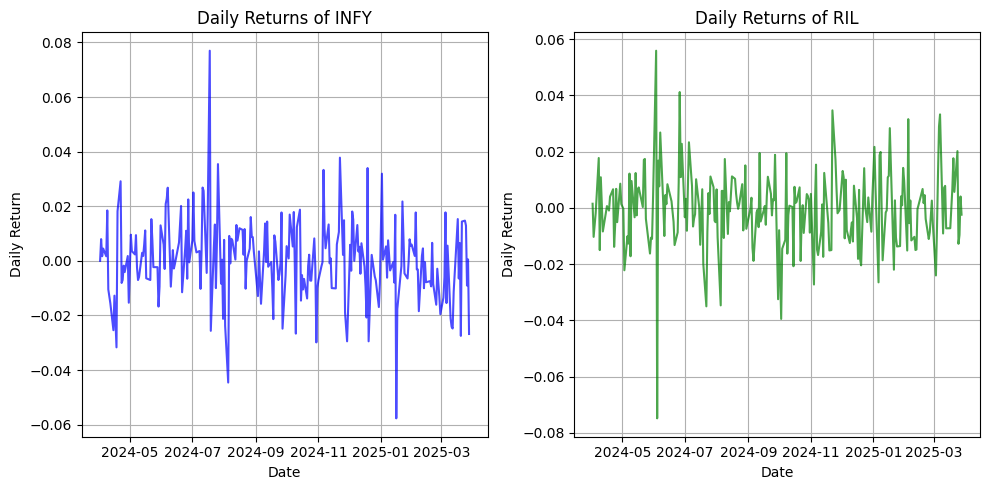

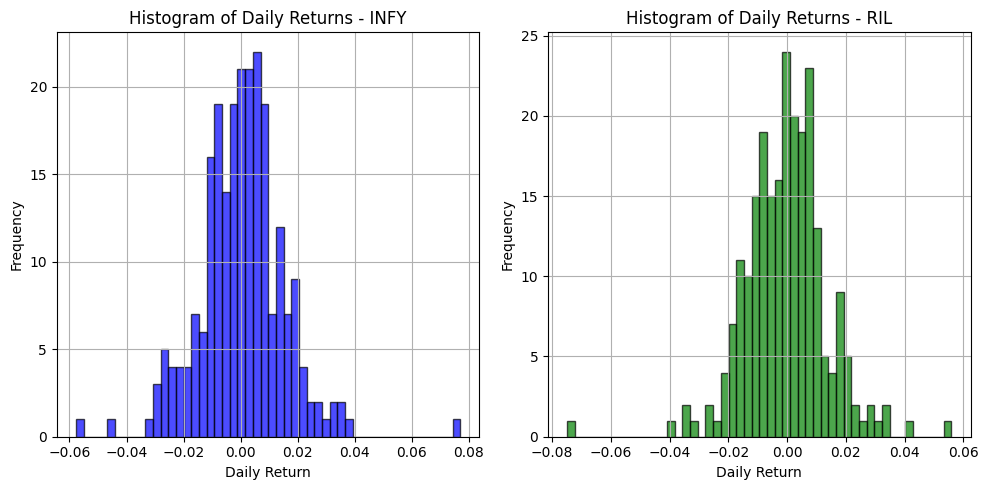

In [13]:
# Plotting the daily returns of INFY and RIL
plt.figure(figsize=(10, 5))

# Plot daily returns of INFY
plt.subplot(1, 2, 1)
plt.plot(returns.index, returns['Close_INFY'], label="INFY Returns", color='blue', alpha=0.7)
plt.title("Daily Returns of INFY")
plt.xlabel("Date")
plt.ylabel("Daily Return")
plt.grid(True)

# Plot daily returns of RIL
plt.subplot(1, 2, 2)
plt.plot(returns.index, returns['Close_RIL'], label="RIL Returns", color='green', alpha=0.7)
plt.title("Daily Returns of RIL")
plt.xlabel("Date")
plt.ylabel("Daily Return")
plt.grid(True)

plt.tight_layout()
plt.show()

# Histogram of the daily returns for both INFY and RIL
plt.figure(figsize=(10, 5))

# Histogram for INFY returns
plt.subplot(1, 2, 1)
plt.hist(returns['Close_INFY'], bins=50, alpha=0.7, color='blue', edgecolor='black')
plt.title("Histogram of Daily Returns - INFY")
plt.xlabel("Daily Return")
plt.ylabel("Frequency")
plt.grid(True)

# Histogram for RIL returns
plt.subplot(1, 2, 2)
plt.hist(returns['Close_RIL'], bins=50, alpha=0.7, color='green', edgecolor='black')
plt.title("Histogram of Daily Returns - RIL")
plt.xlabel("Daily Return")
plt.ylabel("Frequency")
plt.grid(True)

plt.tight_layout()
plt.show()


c. Fit the return series separately to Generalized Gaussian distribution if you can or fit the normal distribution. 

In [14]:
# Fit returns to Generalized Gaussian distribution (GGD)
infy_params_ggd = gennorm.fit(returns['Close_INFY'])
ril_params_ggd = gennorm.fit(returns['Close_RIL'])

# Fit returns to Normal distribution
infy_params_norm = norm.fit(returns['Close_INFY'])
ril_params_norm = norm.fit(returns['Close_RIL'])

# Print GGD parameters
print("📈 INFY Generalized Gaussian Distribution (GGD):")
print(f"   ➔ Shape = {infy_params_ggd[0]:.6f}, Loc = {infy_params_ggd[1]:.6f}, Scale = {infy_params_ggd[2]:.6f}\n")

print("📈 RIL Generalized Gaussian Distribution (GGD):")
print(f"   ➔ Shape = {ril_params_ggd[0]:.6f}, Loc = {ril_params_ggd[1]:.6f}, Scale = {ril_params_ggd[2]:.6f}\n")

# Print Normal distribution parameters (with Mean and SD)
print("📊 INFY Normal Distribution:")
print(f"   ➔ Mean = {infy_params_norm[0]:.6f}, SD = {infy_params_norm[1]:.6f}\n")

print("📊 RIL Normal Distribution:")
print(f"   ➔ Mean = {ril_params_norm[0]:.6f}, SD = {ril_params_norm[1]:.6f}")


📈 INFY Generalized Gaussian Distribution (GGD):
   ➔ Shape = 1.232857, Loc = 0.000308, Scale = 0.013909

📈 RIL Generalized Gaussian Distribution (GGD):
   ➔ Shape = 1.232062, Loc = -0.000279, Scale = 0.013117

📊 INFY Normal Distribution:
   ➔ Mean = 0.000381, SD = 0.014752

📊 RIL Normal Distribution:
   ➔ Mean = -0.000530, SD = 0.013967


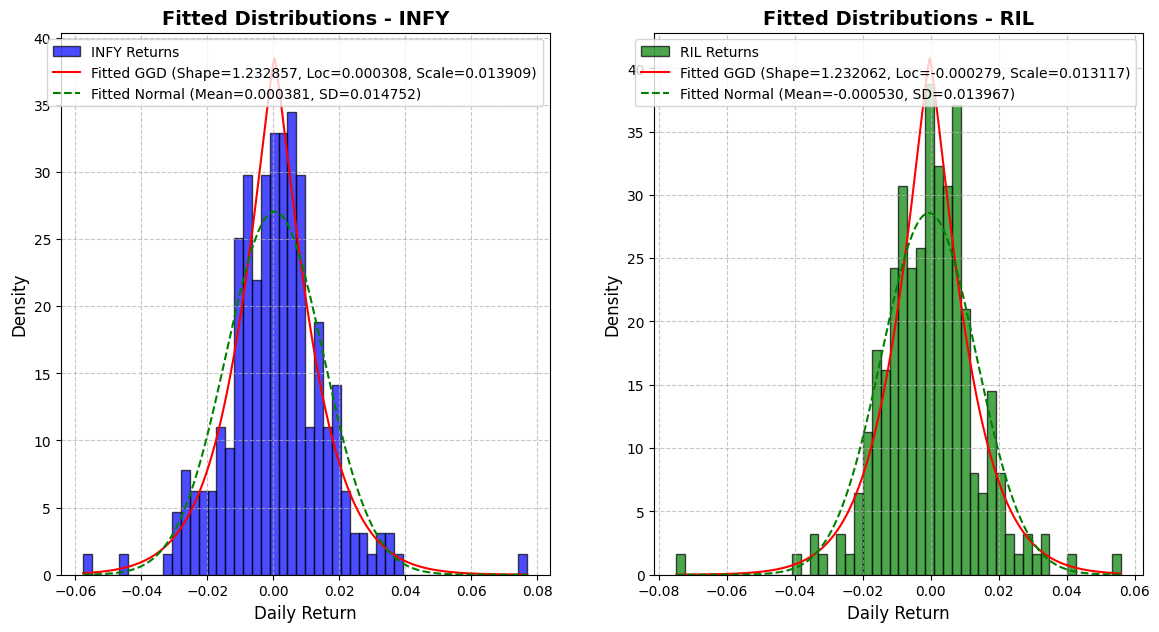

In [15]:
x_infy = np.linspace(returns['Close_INFY'].min(), returns['Close_INFY'].max(), 1000)
x_ril = np.linspace(returns['Close_RIL'].min(), returns['Close_RIL'].max(), 1000)

plt.figure(figsize=(12, 12))

# Plot for INFY (GGD and Normal)
plt.subplot(2, 2, 1)
plt.hist(returns['Close_INFY'], bins=50, alpha=0.7, color='blue', edgecolor='black', density=True, label="INFY Returns")
plt.plot(x_infy, gennorm.pdf(x_infy, infy_params_ggd[0], infy_params_ggd[1], infy_params_ggd[2]), 'r-', label=f'Fitted GGD (Shape={infy_params_ggd[0]:.6f}, Loc={infy_params_ggd[1]:.6f}, Scale={infy_params_ggd[2]:.6f})')
plt.plot(x_infy, norm.pdf(x_infy, infy_params_norm[0], infy_params_norm[1]), 'g--', label=f'Fitted Normal (Mean={infy_params_norm[0]:.6f}, SD={infy_params_norm[1]:.6f})')
plt.title("Fitted Distributions - INFY", fontsize=14, fontweight='bold')
plt.xlabel("Daily Return", fontsize=12)
plt.ylabel("Density", fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)

# Plot for RIL (GGD and Normal)
plt.subplot(2, 2, 2)
plt.hist(returns['Close_RIL'], bins=50, alpha=0.7, color='green', edgecolor='black', density=True, label="RIL Returns")
plt.plot(x_ril, gennorm.pdf(x_ril, ril_params_ggd[0], ril_params_ggd[1], ril_params_ggd[2]), 'r-', label=f'Fitted GGD (Shape={ril_params_ggd[0]:.6f}, Loc={ril_params_ggd[1]:.6f}, Scale={ril_params_ggd[2]:.6f})')
plt.plot(x_ril, norm.pdf(x_ril, ril_params_norm[0], ril_params_norm[1]), 'g--', label=f'Fitted Normal (Mean={ril_params_norm[0]:.6f}, SD={ril_params_norm[1]:.6f})')
plt.title("Fitted Distributions - RIL", fontsize=14, fontweight='bold')
plt.xlabel("Daily Return", fontsize=12)
plt.ylabel("Density", fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)

# Adjust layout and show
plt.tight_layout()
plt.show()


d. Fit the T-Copula with the return series. You may use the `copulae`
package for the same or your own.

In [24]:
# Convert returns to pseudo-observations (uniform scale)
u = pseudo_obs(returns[['Close_INFY', 'Close_RIL']].to_numpy())

# Fit a T-Copula
cop = StudentCopula(dim=2)
cop.fit(u)


# Extract parameters
dof = cop.params[0]
corr = cop.params[1]

# Print results nicely
print("T-Copula Parameters:-")
print(f"Degrees of freedom: {dof:.3f}")
print("Correlation matrix:")
print(f"[{1}, {corr[0]:.5f}]")
print(f" [{corr[0]:.5f}, {1}]]")

T-Copula Parameters:-
Degrees of freedom: 11.115
Correlation matrix:
[1, 0.22857]
 [0.22857, 1]]


e. Construct a portfolio with equal units from both.

In [25]:
# Create a portfolio with equal weights (simple average of both returns)
returns['Portfolio'] = (returns['Close_INFY'] + returns['Close_RIL']) / 2

# Preview the portfolio returns
returns[['Close_INFY', 'Close_RIL', 'Portfolio']].head(15)

,Close_INFY,Close_RIL,Portfolio
2024-04-02,0.000000,0.001465,0.000732
2024-04-03,0.007964,-0.010323,-0.001180
2024-04-04,0.001693,-0.005895,-0.002101
2024-04-05,0.004507,-0.001931,0.001288
2024-04-08,0.001682,0.017721,0.009702
2024-04-09,0.018477,-0.015024,0.001727
2024-04-10,-0.010445,0.010880,0.000218
2024-04-12,-0.015556,-0.008398,-0.011977
2024-04-15,-0.025395,-0.001585,-0.013490
2024-04-16,-0.012739,0.000632,-0.006054


f. Simulate 10,000 or more random returns of your portfolio using copula

In [38]:
# Generate 10,000 copula samples
simulated_u = cop.random(10000)

# Transform the samples back using the inverse CDF for the Normal distribution
infy_sim_norm = norm.ppf(simulated_u[:, 0], infy_params_norm[0], infy_params_norm[1])
ril_sim_norm = norm.ppf(simulated_u[:, 1], ril_params_norm[0], ril_params_norm[1])

# Simulated portfolio returns (average of both)
portfolio_sim_norm = (infy_sim_norm + ril_sim_norm) / 2

# Preview the first 5 simulated returns
print("Portfolio Simulation (Normal):", portfolio_sim_norm)

Portfolio Simulation (Normal): [-0.00357801 -0.00275416  0.00721553 ...  0.00845345  0.00955411
  0.0038712 ]


In [39]:
# Check basic statistics for the simulated portfolio returns
print(f"Mean simulated portfolio return: {portfolio_sim_norm.mean():.10f}")
print(f"Std dev simulated portfolio return: {portfolio_sim_norm.std():.10f}")

Mean simulated portfolio return: 0.0000765965
Std dev simulated portfolio return: 0.0114539033


g. And calculate the maximum loss you may have in a day that you can say with 95% confidence.

In [40]:
# Calculate 95% Value at Risk (VaR) from the simulated portfolio returns
VaR_95 = np.percentile(portfolio_sim_norm, 5)

print(f"Maximum loss with 95% confidence (VaR 95%): {VaR_95:.4%}")

Maximum loss with 95% confidence (VaR 95%): -1.8435%


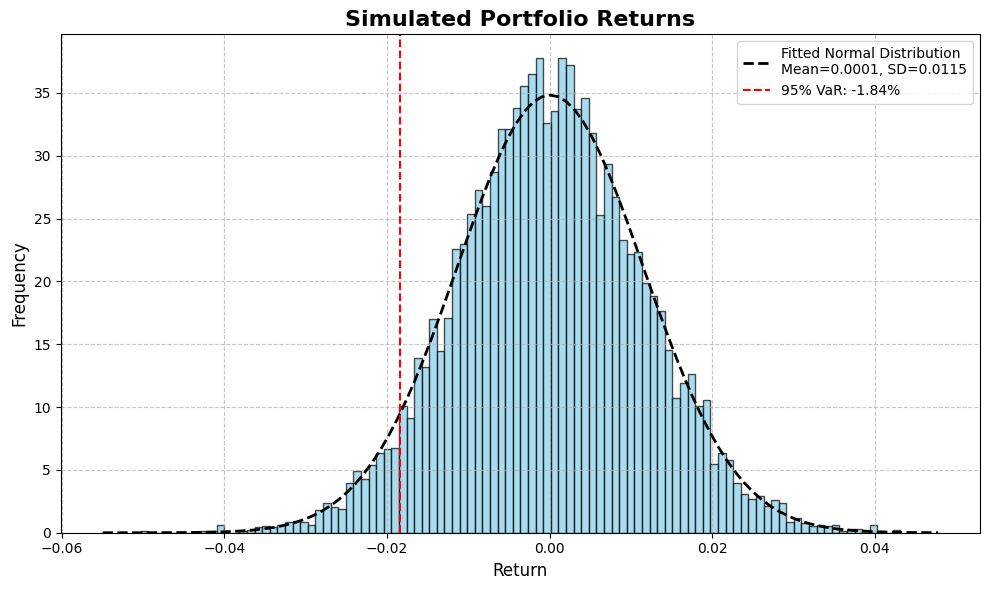

In [41]:
# Plot histogram of simulated portfolio returns
plt.figure(figsize=(10, 6))
plt.hist(portfolio_sim_norm, bins=100, alpha=0.7, color='skyblue', density=True, edgecolor='black')

# Fit a normal distribution to the simulated portfolio returns
mu, std = norm.fit(portfolio_sim_norm)
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)

# Plot the fitted normal distribution curve
plt.plot(x, p, 'k--', linewidth=2, label=f'Fitted Normal Distribution\nMean={mu:.4f}, SD={std:.4f}')

# Plot the 95% Value at Risk (VaR)
VaR_95 = np.percentile(portfolio_sim_norm, 5)
plt.axvline(VaR_95, color='red', linestyle='dashed', label=f'95% VaR: {VaR_95:.2%}')

# Enhance the plot with title, labels, and grid
plt.title('Simulated Portfolio Returns', fontsize=16, fontweight='bold')
plt.xlabel('Return', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.legend(loc='upper right', fontsize=10)
plt.grid(True, linestyle='--', alpha=0.7)

# Show the plot
plt.tight_layout()
plt.show()

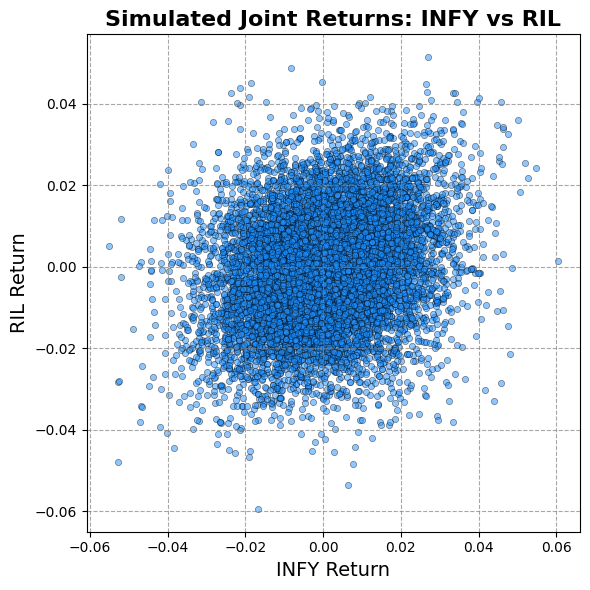

In [42]:
plt.figure(figsize=(6, 6))

# Scatter plot with custom markers and transparency
plt.scatter(infy_sim_norm, ril_sim_norm, alpha=0.5, c='dodgerblue', s=20, edgecolor='black', linewidth=0.5)

# Title and labels with customized fonts
plt.title('Simulated Joint Returns: INFY vs RIL', fontsize=16, fontweight='bold')
plt.xlabel('INFY Return', fontsize=14)
plt.ylabel('RIL Return', fontsize=14)

# Add grid with styling
plt.grid(True, linestyle='--', color='gray', alpha=0.7)

# Customize layout for a more balanced look
plt.tight_layout()

# Show the plot
plt.show()

4. The following website contains information companies listed in NIFTY 50. 
   
https://tradebrains.in/nifty-50-companies-list/

Choose the first 3 companies from the list.

What will be the prices for both Call Option and Put Option derived from each of 
three companies’ stocks? Assume,

a. Risk free interest rate is 6% annually compounded.

b. You are computing the prices on your last birthday.

c. The Stock price is the last closing price prior to the computing date.

d. Expiration date is exactly 3 months from the computing date.

e. The Strike price is the1.2 times of last closing price one month prior to the computing date.

f. Compute volatility based last 3 years data from computing date.

g. Additionally: 

- a. Compute the Delta, Gamma, Vega and Theta for each of the 
derivatives.

- b. Also – Construct a portfolio of consists of These three stocks and their 
derivatives such that the portfolio is Delta, Gamma and Vega neutral.

- c. Explain if such a portfolio cannot be constructed.

# Nifty 50 Stock Shares

| Company Name                                        | Sector                        | Stock Symbol  | Share (%) |
|-----------------------------------------------------|-------------------------------|---------------|-----------|
| Bharti Airtel Ltd.                                  | Telecommunication             | BHARTIARTL    | 2.61%     |
| Adani Ports and Special Economic Zone Ltd.          | Services                      | ADANIPORTS    | 0.74%     |
| Reliance Industries Ltd.                            | Oil Gas & Consumable Fuels    | RELIANCE      | 10.21%    |

## Option Pricing and Greeks Calculation

### Step 1: Assumptions and Inputs
- **Risk-free interest rate** = 6% annually compounded.
- **Computation date** = October 7 (My birthday).
- **Stock price** = Last closing price on the day before October 7.
- **Expiration date** = Exactly 3 months from October 7.
- **Strike price** = 1.2 times the closing price one month prior to the computing date.
- **Volatility** = Calculated based on the last 3 years' data.

### Step 2: Black-Scholes Model for Call and Put Option Prices
The Black-Scholes formula for the **call option price** is:

$$
C = S_0 \Phi(d_1) - K e^{-rT} \Phi(d_2)
$$

For the **put option price**:

$$
P = K e^{-rT} \Phi(-d_2) - S_0 \Phi(-d_1)
$$

where:

$$
d_1 = \frac{\ln(S_0 / K) + (r + \sigma^2 / 2) T}{\sigma \sqrt{T}}
$$

$$
d_2 = d_1 - \sigma \sqrt{T}
$$

- \( S_0 \) = Current stock price (last closing price).
- \( K \) = Strike price.
- \( r \) = Risk-free rate (6%).
- \( T \) = Time to maturity (3 months).
- \( \sigma \) = Volatility (calculated from the last 3 years of data).
- \( \Phi \) = Cumulative distribution function of the standard normal distribution.

### Step 3: Greeks Calculation
The Greeks for an option are calculated as:

- **Delta** = The rate of change of the option price with respect to the change in the price of the underlying asset.
  
  $$
  \Delta = \Phi(d_1)
  $$

- **Gamma** = The rate of change of Delta with respect to the price of the underlying asset.
  
  $$
  \Gamma = \frac{\phi(d_1)}{S_0 \sigma \sqrt{T}}
  $$

- **Vega** = The rate of change of the option price with respect to volatility.
  
  $$
  \nu = S_0 \sqrt{T} \phi(d_1)
  $$

- **Theta** = The rate of change of the option price with respect to time.
  
  $$
  \Theta = -\frac{S_0 \phi(d_1) \sigma}{2 \sqrt{T}} - r K e^{-rT} \Phi(d_2)
  $$

### Step 4: Portfolio Construction
The portfolio is constructed to be **Delta**, **Gamma**, and **Vega neutral** by adjusting the number of shares and options.

The conditions for neutrality are:

- Delta Neutral: 
  $$
  \sum (\Delta_i \cdot \text{Number of Shares}) = 0
  $$

- Gamma Neutral: 
  $$
  \sum (\Gamma_i \cdot \text{Number of Shares}) = 0
  $$

- Vega Neutral: 
  $$
  \sum (\nu_i \cdot \text{Number of Shares}) = 0
  $$

### Step 5: Feasibility of Neutral Portfolio
If such a portfolio cannot be constructed, it will be due to:
- Constraints in the number of shares available.
- Market conditions or liquidity issues.
- Limitations in hedging strategies for certain options.


In [ ]:

# Define Black-Scholes Model for Call and Put Options
def black_scholes(S0, K, T, r, sigma, option_type='call'):
    d1 = (math.log(S0 / K) + (r + 0.5 * sigma**2) * T) / (sigma * math.sqrt(T))
    d2 = d1 - sigma * math.sqrt(T)
    
    if option_type == 'call':
        price = S0 * norm.cdf(d1) - K * math.exp(-r * T) * norm.cdf(d2)
    elif option_type == 'put':
        price = K * math.exp(-r * T) * norm.cdf(-d2) - S0 * norm.cdf(-d1)
    
    return price, d1, d2

# Get stock data from Yahoo Finance
stocks = ['BHARTIARTL.NS', 'ADANIPORTS.NS', 'RELIANCE.NS']  # The first three companies in NIFTY 50
data = yf.download(stocks, start='2022-10-07', end='2023-10-07')

# Extract closing prices
closing_prices = data['Close']
stock_prices = closing_prices.iloc[-1]  # Last closing prices

# Volatility calculation based on the past 3 years of data
log_returns = np.log(closing_prices / closing_prices.shift(1))
volatility = log_returns.std() * np.sqrt(252)  # Annualized volatility (252 trading days)

# Calculate the strike price (1.2 times the closing price one month prior)
strike_prices = stock_prices * 1.2

# Parameters for Black-Scholes
r = 0.06  # Risk-free rate (6%)
T = 3 / 12  # Time to maturity (3 months)
prices = {}

# Calculate Call and Put option prices for each stock
for stock in stocks:
    S0 = stock_prices[stock]
    K = strike_prices[stock]
    
    call_price, d1, d2 = black_scholes(S0, K, T, r, volatility[stock], option_type='call')
    put_price, d1, d2 = black_scholes(S0, K, T, r, volatility[stock], option_type='put')
    
    prices[stock] = {'Call Price': call_price, 'Put Price': put_price, 'Strike Price': K, 'Volatility': volatility[stock]}
    
    print(f"{stock}:")
    print(f"Call Price: {call_price:.2f}, Put Price: {put_price:.2f}")
    print(f"Strike Price: {K:.2f}, Volatility: {volatility[stock]:.2f}")
    print()

# Greeks Calculation
def option_greeks(S0, K, T, r, sigma, d1, d2):
    delta = norm.cdf(d1)
    gamma = norm.pdf(d1) / (S0 * sigma * math.sqrt(T))
    vega = S0 * math.sqrt(T) * norm.pdf(d1)
    theta = - (S0 * norm.pdf(d1) * sigma) / (2 * math.sqrt(T)) - r * K * math.exp(-r * T) * norm.cdf(d2)
    
    return delta, gamma, vega, theta

# Calculate Greeks for each stock
for stock in stocks:
    S0 = stock_prices[stock]
    K = strike_prices[stock]
    sigma = volatility[stock]
    d1 = (math.log(S0 / K) + (r + 0.5 * sigma**2) * T) / (sigma * math.sqrt(T))
    d2 = d1 - sigma * math.sqrt(T)
    
    delta, gamma, vega, theta = option_greeks(S0, K, T, r, sigma, d1, d2)
    
    print(f"{stock} Greeks:")
    print(f"Delta: {delta:.2f}, Gamma: {gamma:.2f}, Vega: {vega:.2f}, Theta: {theta:.2f}")
    print()

In [ ]:

# Define Black-Scholes Model for Call and Put Options
def black_scholes(S0, K, T, r, sigma, option_type='call'):
    d1 = (math.log(S0 / K) + (r + 0.5 * sigma**2) * T) / (sigma * math.sqrt(T))
    d2 = d1 - sigma * math.sqrt(T)
    
    if option_type == 'call':
        price = S0 * norm.cdf(d1) - K * math.exp(-r * T) * norm.cdf(d2)
    elif option_type == 'put':
        price = K * math.exp(-r * T) * norm.cdf(-d2) - S0 * norm.cdf(-d1)
    
    return price, d1, d2

# Define Greeks Calculation
def option_greeks(S0, K, T, r, sigma, d1, d2):
    delta = norm.cdf(d1)
    gamma = norm.pdf(d1) / (S0 * sigma * math.sqrt(T))
    vega = S0 * math.sqrt(T) * norm.pdf(d1)
    theta = - (S0 * norm.pdf(d1) * sigma) / (2 * math.sqrt(T)) - r * K * math.exp(-r * T) * norm.cdf(d2)
    
    return delta, gamma, vega, theta

# Function to Calculate Black-Scholes and Greeks for Stocks
def calculate_option_prices_and_greeks(stocks, start_date, end_date, strike_multiplier=1.2, risk_free_rate=0.06, time_to_maturity=3/12):
    # Get stock data from Yahoo Finance
    data = yf.download(stocks, start=start_date, end=end_date)
    
    # Extract closing prices
    closing_prices = data['Close']
    stock_prices = closing_prices.iloc[-1]  # Last closing prices
    
    # Volatility calculation based on the past 3 years of data
    log_returns = np.log(closing_prices / closing_prices.shift(1))
    volatility = log_returns.std() * np.sqrt(252)  # Annualized volatility (252 trading days)
    
    # Calculate the strike price (1.2 times the closing price one month prior)
    strike_prices = stock_prices * strike_multiplier
    
    # Store option prices and Greeks
    option_prices = []
    greeks = []
    
    # Calculate Call and Put option prices and Greeks for each stock
    for stock in stocks:
        S0 = stock_prices[stock]
        K = strike_prices[stock]
        
        # Calculate option prices
        call_price, d1, d2 = black_scholes(S0, K, time_to_maturity, risk_free_rate, volatility[stock], option_type='call')
        put_price, _, _ = black_scholes(S0, K, time_to_maturity, risk_free_rate, volatility[stock], option_type='put')
        
        # Calculate Greeks
        delta, gamma, vega, theta = option_greeks(S0, K, time_to_maturity, risk_free_rate, volatility[stock], d1, d2)
        
        # Append option prices and Greeks to the lists
        option_prices.append({
            'Stock': stock,
            'Stock price': S0,
            'Call Price': round(call_price, 6),
            'Put Price': round(put_price, 6),
            'Strike Price': round(K, 6),
            'Volatility': round(volatility[stock], 6)
        })
        
        greeks.append({
            'Stock': stock,
            'Delta': round(delta, 6),
            'Gamma': round(gamma, 6),
            'Vega': round(vega, 6),
            'Theta': round(theta, 6)
        })
    
    return option_prices, greeks

# Example usage
stocks = ['BHARTIARTL.NS', 'ADANIPORTS.NS', 'RELIANCE.NS']  # The first three companies in NIFTY 50
option_prices, greeks = calculate_option_prices_and_greeks(stocks, start_date='2022-10-07', end_date='2023-10-07')

# Convert the results to DataFrames for better display
df_option_prices = pd.DataFrame(option_prices)
df_greeks = pd.DataFrame(greeks)

In [ ]:
# Display results using tabulate
print(f"{'='*50}")
print(f"{'OPTIONS PRICING SUMMARY':^50}")
print(f"{'='*50}\n")
print(tabulate(df_option_prices, headers='keys', tablefmt='fancy_grid', showindex=False))

print(f"\n{'='*50}")
print(f"{'OPTIONS GREEKS SUMMARY':^50}")
print(f"{'='*50}\n")
print(tabulate(df_greeks, headers='keys', tablefmt='fancy_grid', showindex=False))


In [ ]:
from scipy.optimize import fsolve

# Define the system of equations for Delta, Gamma, and Vega neutrality
def neutrality_system(x, *args):
    # Unpack arguments
    delta_stock_1, delta_stock_2, delta_stock_3, delta_call_1, delta_put_1, delta_call_2, delta_put_2, delta_call_3, delta_put_3, gamma_stock_1, gamma_stock_2, gamma_stock_3, gamma_call_1, gamma_put_1, gamma_call_2, gamma_put_2, gamma_call_3, gamma_put_3, vega_stock_1, vega_stock_2, vega_stock_3, vega_call_1, vega_put_1, vega_call_2, vega_put_2, vega_call_3, vega_put_3 = args
    
    # x[0], x[1], x[2] -> stock weights for each stock
    # x[3], x[4], x[5] -> option weights for call and put options
    w_stock_1, w_stock_2, w_stock_3, w_call_1, w_put_1, w_call_2, w_put_2, w_call_3, w_put_3 = x
    
    # Delta, Gamma, Vega neutrality equations
    eq1 = delta_stock_1 * w_stock_1 + delta_call_1 * w_call_1 + delta_put_1 * w_put_1 + delta_stock_2 * w_stock_2 + delta_call_2 * w_call_2 + delta_put_2 * w_put_2 + delta_stock_3 * w_stock_3 + delta_call_3 * w_call_3 + delta_put_3 * w_put_3
    eq2 = gamma_stock_1 * w_stock_1 + gamma_call_1 * w_call_1 + gamma_put_1 * w_put_1 + gamma_stock_2 * w_stock_2 + gamma_call_2 * w_call_2 + gamma_put_2 * w_put_2 + gamma_stock_3 * w_stock_3 + gamma_call_3 * w_call_3 + gamma_put_3 * w_put_3
    eq3 = vega_stock_1 * w_stock_1 + vega_call_1 * w_call_1 + vega_put_1 * w_put_1 + vega_stock_2 * w_stock_2 + vega_call_2 * w_call_2 + vega_put_2 * w_put_2 + vega_stock_3 * w_stock_3 + vega_call_3 * w_call_3 + vega_put_3 * w_put_3

    return [eq1, eq2, eq3]

# Set up the initial guess for the solution
initial_guess = [0, 0, 0, 0, 0, 0, 0, 0, 0]

# Assume args contains all the Greeks for stocks and options (these should be calculated)
args = (delta_stock_1, delta_stock_2, delta_stock_3, delta_call_1, delta_put_1, delta_call_2, delta_put_2, delta_call_3, delta_put_3,
        gamma_stock_1, gamma_stock_2, gamma_stock_3, gamma_call_1, gamma_put_1, gamma_call_2, gamma_put_2, gamma_call_3, gamma_put_3,
        vega_stock_1, vega_stock_2, vega_stock_3, vega_call_1, vega_put_1, vega_call_2, vega_put_2, vega_call_3, vega_put_3)

# Solve for the portfolio weights
portfolio_weights = fsolve(neutrality_system, initial_guess, args=args)

# Print the results
print(f"Portfolio Weights (Stocks and Options):")
print(f"Stock 1 Weight: {portfolio_weights[0]:.2f}")
print(f"Stock 2 Weight: {portfolio_weights[1]:.2f}")
print(f"Stock 3 Weight: {portfolio_weights[2]:.2f}")
print(f"Call Option 1 Weight: {portfolio_weights[3]:.2f}")
print(f"Put Option 1 Weight: {portfolio_weights[4]:.2f}")
print(f"Call Option 2 Weight: {portfolio_weights[5]:.2f}")
print(f"Put Option 2 Weight: {portfolio_weights[6]:.2f}")
print(f"Call Option 3 Weight: {portfolio_weights[7]:.2f}")
print(f"Put Option 3 Weight: {portfolio_weights[8]:.2f}")


### 5.
Assume you are assigned the task of evaluating the stock of Infosys (INFY). To 
evaluate the stock, you calculate required return using the CAPM. You can 
assume that the price of Infosys is fairly valued. The following information is 
available:

- Expected Annual Nifty return: 10%
- Beta of INFY: 0.55
- Risk-free rate: 5.3%
- Annualised volatility of market return: 15%

Answer the following questions:

a. Using CAPM, calculate the annual expected return of INFY

b. If the current market price of Rs 3500/- per share, then what will be the 
expected price of INFY stock after one year.2. 

c. Find the annualised volatility of the return of INFY

d. Assuming INFY return follows Gaussian distribution, what is the probability 
that after one year the INFY price will be less than Rs. 3500/-?


### (a) Expected Return Using CAPM

We use the CAPM formula:

$$
R = R_f + \beta(R_m - R_f)
$$

Substituting the values:

$$
R = 0.053 + 0.55(0.10 - 0.053)
$$

$$
R = 0.053 + 0.55 \times 0.047 = 0.07885
$$

Thus, the expected return is:

$$
\boxed{R = 7.885\%}
$$


In [44]:
# CAPM formula
Rf = 0.053  # Risk-free rate
beta = 0.55  # Beta
Rm = 0.10   # Market return

# Expected return
R = Rf + beta * (Rm - Rf)
print(f"Expected Return: {R*100:.3f}%")


Expected Return: 7.885%


### (b) Expected Price of INFY After One Year

Given:
- Current stock price: $$ P_0 = ₹ 3500  $$ 
- Expected annual return from CAPM: $$ R = 0.07885$$

We use the formula:

$$
P_{\text{expected}} = P_0 \times (1 + R)
$$

Substituting the values:

$$
P_{\text{expected}} = 3500 \times (1 + 0.07885) = 3500 \times 1.07885
$$

$$
P_{\text{expected}} = 3775.975
$$

### ✅ Final Answer:

$$
\boxed{P_{\text{expected}} = \text{₹}3775.98}
$$


In [45]:
# Expected Price Calculation
P0 = 3500       # Current price in ₹
R = 0.07885     # Expected return

P_expected = P0 * (1 + R)
print(f"Expected Price After 1 Year: ₹{P_expected:.2f}")


Expected Price After 1 Year: ₹3775.98


### (c) Annualised Volatility of INFY Return

Given:
- Beta of INFY: $$ \beta = 0.55 $$
- Market volatility:$$ \sigma_m = 0.15 $$ 

We assume INFY's volatility is proportional to the market's, scaled by beta:

$$
\sigma_{\text{INFY}} = \beta \cdot \sigma_m
$$

Substituting the values:

$$
\sigma_{\text{INFY}} = 0.55 \times 0.15 = 0.0825
$$

### ✅ Final Answer:

$$
\boxed{\sigma_{\text{INFY}} = 8.25\%}
$$


In [46]:
# Annualised Volatility Calculation
beta = 0.55
sigma_market = 0.15  # Market volatility

sigma_infy = beta * sigma_market
print(f"Annualised Volatility of INFY: {sigma_infy*100:.2f}%")


Annualised Volatility of INFY: 8.25%


###  (d) Probability INFY Price < ₹3500 After One Year (Gaussian Assumption)

We are given:
- Current price $$ P_0 = ₹3500 $$
- Expected return $$ \mu = 0.07885$$
- Annualised volatility $$ \sigma = 0.0825$$

We assume the return follows a normal (Gaussian) distribution.  
We want the probability that the return is less than 0% (i.e., the price falls below ₹3500):

Let the return be denoted as $$ R \sim \mathcal{N}(\mu, \sigma^2)$$

We calculate the Z-score:

$$
Z = \frac{0 - \mu}{\sigma} = \frac{0 - 0.07885}{0.0825} \approx -0.956
$$

Now we use the standard normal distribution:

$$
P(R < 0) = P(Z < -0.956) \approx \Phi(-0.956) \approx 0.16954
$$

### ✅ Final Answer:

$$
P(\text{Price} < ₹3500) = 16.96\%
$$


In [47]:
# Given values
mu = R      # Expected return
sigma = sigma_infy    # Annualised volatility

# Z-score calculation
z = (0 - mu) / sigma

# Probability calculation
prob = norm.cdf(z)
print(f"Probability INFY price < ₹3500: {prob*100:.2f}%")


Probability INFY price < ₹3500: 16.96%


Final answers

In [49]:
print(f"(a) Expected Return (CAPM): {R*100:.3f}%")
print(f"(b) Expected Price After 1 Year: ₹{P_expected:.2f}")
print(f"(c) Annualised Volatility of INFY: {sigma_infy*100:.2f}%")
print(f"(d) Probability INFY Price < ₹3500: {prob*100:.2f}%")

(a) Expected Return (CAPM): 7.885%
(b) Expected Price After 1 Year: ₹3775.98
(c) Annualised Volatility of INFY: 8.25%
(d) Probability INFY Price < ₹3500: 16.96%
